<a href="https://colab.research.google.com/github/scottspurlock/noisy_labels/blob/main/basic_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with noisy labels
## Scott Spurlock
### Created: 12-17-2020

Adapted from
- Autoencoder tutorial: https://learnopencv.com/autoencoder-in-tensorflow-2-beginners-guide/
- VAE tutorial: https://learnopencv.com/variational-autoencoder-in-tensorflow/

## Goal
Train an accurate classifier when the labels are not completely accurate. Originally, the application was to train a single frame classifier to detect deepfakes when the labels were at the sequence level, which could lead to some non-fake frames being labeled as fake, though not vice versa.

## Experiments
### Models
- Train a vanilla classifier
- Train a vanilla classifier, but impose a sparsity constraint on the penultimate layer
- Train an autoencoder with a separate classification head
- Train a VAE with a separate classification head
- Train a VAE with a separate classification head and some additional loss that makes noisy classification better

### Data
- Focus on MNIST to start
- Binary vs multi-class
- Uniform random label flipping at a variety of probabilities
- Biased flipping, where one class is labeled as another, but not vice versa


# Exemplar Model
Create a layer with M nodes with the goal that each node is a "detector" that activates in a local region. We want:
- no detectors to fire (predict 1) when the true label is 0
- exactly one detector to fire when the true label is 1 (may be noisy)

The first goal can be met by comparing summed prediction across the outputs to 0.

The second goal can be met by either
- taking the L1 norm across the predictions to encourage sparsity
- taking the loss only on the highest valued output

## Model outputs
The model should output the exemplar scores as well as a trainable final layer that learns to predict based on the penultimate layer. This requires having two outputs and two losses.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
latent_dim = 2
input_shape = (28, 28, 1)
epochs = 10
batch_size = 128
num_classes = 10
learning_rate = 5e-4
# num_exemplars = 3


# ============================================================
# Baseline classifier

In [3]:
def encoder(input_shape):
    inputs = keras.Input(shape=input_shape, name='input_layer')
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(latent_dim, name='latent_out')(x)
    model = tf.keras.Model(inputs, x, name='encoder')
    return model

In [4]:
def classifier():
    inputs = keras.Input(shape=(latent_dim,), name='input_layer')
    outp = layers.Dense(num_classes, activation="softmax", name='classifier_out')(inputs)
    model = tf.keras.Model(inputs, outp, name="classifier")
    return model

### Load the data

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)


# One-hot encode the labels
y_train_one_hot = keras.utils.to_categorical(y_train, num_classes)
y_test_one_hot = keras.utils.to_categorical(y_test, num_classes)

print('y_train shape:', y_train.shape)
print('y_train_one_hot shape:', y_train.shape)

n_train = x_train.shape[0]

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (60000,)
y_train_one_hot shape: (60000,)


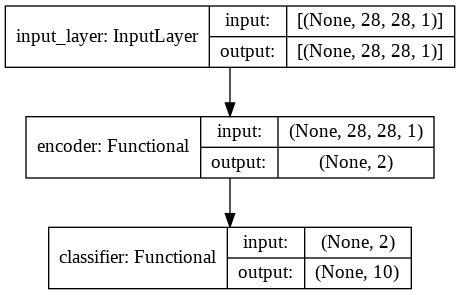

In [9]:
inputs = keras.Input(shape=input_shape, name='input_layer')

enc = encoder(input_shape)
clf = classifier()

model = tf.keras.Model(
			inputs=inputs,
			# outputs=[enc(inputs), clf(enc(inputs))],
			outputs=clf(enc(inputs)),
			name="baseline")

# plot the autoencoder
tf.keras.utils.plot_model(model, 'classifier.png', show_shapes=True)

## Train the model

In [10]:
# losses = {
#     'decoder': 'mse',
#     'classifier': 'categorical_crossentropy',
# }

# wts = {
#     'decoder': 10.0, 
#     'classifier': 1.0
# }

opt = keras.optimizers.Adam(learning_rate=learning_rate)
# model.compile(optimizer=opt, loss=losses, loss_weights=wts, metrics=["accuracy"])
# hist = model.fit(x_train, [x_train, y_train_one_hot], batch_size=batch_size, epochs=epochs, validation_split=0.1)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, y_train_one_hot, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/10
422/422 [==============================] - 33s 5ms/step - loss: 1.4130 - accuracy: 0.4459 - val_loss: 0.9126 - val_accuracy: 0.6092
Epoch 2/10
422/422 [==============================] - 2s 4ms/step - loss: 0.7588 - accuracy: 0.7121 - val_loss: 0.5756 - val_accuracy: 0.8362
Epoch 3/10
422/422 [==============================] - 2s 5ms/step - loss: 0.5446 - accuracy: 0.8507 - val_loss: 0.4367 - val_accuracy: 0.8918
Epoch 4/10
422/422 [==============================] - 2s 5ms/step - loss: 0.4447 - accuracy: 0.8879 - val_loss: 0.3588 - val_accuracy: 0.9127
Epoch 5/10
422/422 [==============================] - 2s 4ms/step - loss: 0.3862 - accuracy: 0.9052 - val_loss: 0.3262 - val_accuracy: 0.9248
Epoch 6/10
422/422 [==============================] - 2s 4ms/step - loss: 0.3454 - accuracy: 0.9167 - val_loss: 0.2824 - val_accuracy: 0.9348
Epoch 7/10
422/422 [==============================] - 2s 4ms/step - loss: 0.3111 - accuracy: 0.9246 - val_loss: 0.2625 - val_accuracy: 0.9352
Epoch

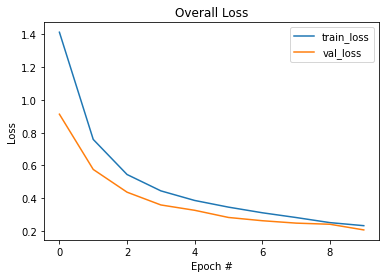

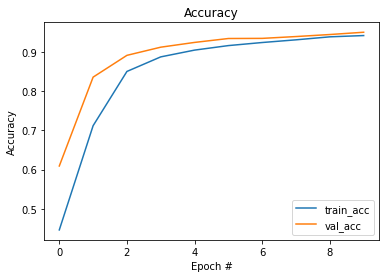

In [13]:
# construct a plot that plots and saves the training history
# plt.style.use("ggplot")
plt.figure()
plt.plot(hist.epoch, hist.history["loss"], label="train_loss")
plt.plot(hist.epoch, hist.history["val_loss"], label="val_loss")
plt.title("Overall Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig('total_loss.png')
plt.show()

plt.figure()
plt.plot(hist.epoch, hist.history["accuracy"], label="train_acc")
plt.plot(hist.epoch, hist.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('classifier_acc.png')
plt.show()



Test Accuracy: 0.9458
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.97      0.98      0.97      1135
           2       0.95      0.95      0.95      1032
           3       0.93      0.94      0.94      1010
           4       0.96      0.95      0.96       982
           5       0.96      0.94      0.95       892
           6       0.98      0.92      0.95       958
           7       0.93      0.95      0.94      1028
           8       0.92      0.91      0.92       974
           9       0.91      0.93      0.92      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



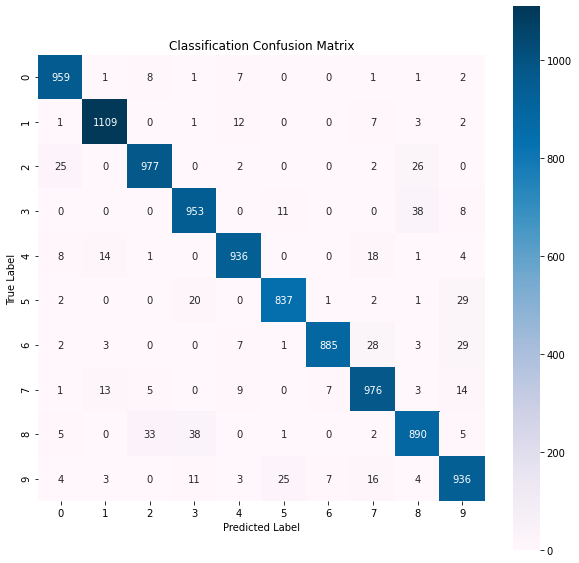

In [14]:
# Check accuracy

# Encode the input image
z = enc(x_test)

# Classify the latent code
y_pred = clf(z)

m = tf.keras.metrics.CategoricalAccuracy()
m.update_state(y_test_one_hot, y_pred)
print('Test Accuracy:', m.result().numpy())

y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(10, 10))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="PuBu")

plt.xlabel('Predicted Label');
plt.ylabel('True Label')
plt.title('Classification Confusion Matrix')
plt.show()


## Display how the latent space clusters different digit classes

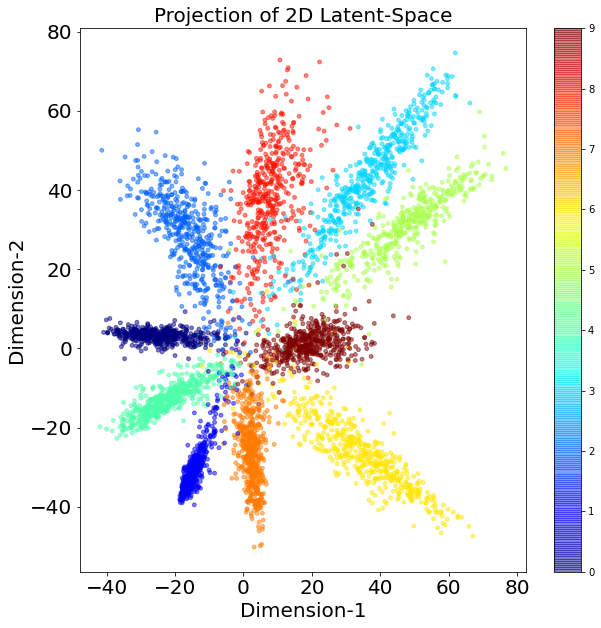

In [15]:
imgs_visualize = 5000
figsize = 10

def plot_label_clusters(data, labels, use_pca=False):
    # display a 2D plot of the digit classes in the latent space
    z = enc.predict(data)

    if use_pca:
      pca = PCA(n_components=2)
      pca.fit(data)
      z = pca.transform(z)


    plt.figure(figsize=(figsize, figsize))
    plt.scatter(z[:, 0], z[:, 1], 15, c=labels, cmap='jet', alpha=0.5)
    plt.colorbar()
    plt.xlabel("Dimension-1", size=20)
    plt.ylabel("Dimension-2", size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.title("Projection of 2D Latent-Space", size=20)
    plt.show()

plot_label_clusters(x_train[:imgs_visualize], y_train[:imgs_visualize])


# --------------------
# To be continued...

## Below here is the original code to experiment with an "exemplar" layer in a classifier to predict binary noisy labels.

## Keep only two classes for binary classification

In [ ]:
# Only keep 2 classes
# mask1 = y_train != 1
# mask2 = y_train == 1
# mask = mask1 | mask2
# y_train[mask1] = 0
# y_train[mask2] = 1
# y_train = y_train[mask]
# x_train = x_train[mask]

# mask1 = y_test != 1
# mask2 = y_test == 1
# mask = mask1 | mask2
# y_test[mask1] = 0
# y_test[mask2] = 1
# y_test = y_test[mask]
# x_test = x_test[mask]

# u = np.unique(y_train)
# num_classes = len(u)


In [ ]:
# Subsample data
keep_frac = 1
n = int(len(x_train) * keep_frac)
x_train = x_train[:n]
y_train = y_train[:n]

print(y_train.shape)
print(x_train.shape)

## Exemplar Loss
The following custom loss implements several ideas for encouraging sparse activations across the exemplar layer.

In [ ]:
class CustomExemplarLoss(keras.losses.Loss):
    def __init__(self, opt=1, name="custom_exemplar_loss"):
        super().__init__(name=name)
        self.opt = opt # Just a placeholder at the moment

    def call(self, y_true, y_pred):
        # Weights for the different terms
        alpha_0 = 1.0
        alpha_1 = 1.0
        alpha_2 = 1.0

        # Find the difference of each prediction from gt
        # with any luck, tf will auto expand y_true
        diff = tf.abs(y_true - y_pred)
        # print('diff:', diff.shape)

        # Find the min difference along the last axis (columns)
        loss = tf.math.reduce_min(diff, axis=-1)
        # print('loss:', loss.shape)

        # Encourage sparsity:
        #   when true is 0, preds are all 0
        #   when true is 1, one pred is 1
        loss_s = tf.math.reduce_sum(diff, axis=-1)

        reg = tf.math.reduce_sum(tf.square(0 - y_pred), axis=-1)

        return alpha_0 * loss \
             + alpha_1 * loss_s \
             + alpha_2 * reg


## Change labels
Change a fraction of the labels from class 0 to class 1.

In [ ]:
# Corrupt labels
change_frac = 0.5
# m = int(n * change_frac)
# rp = np.random.permutation(n)[:m]
# new_labels = np.random.randint(0, num_classes, m)
# y_train[rp] = new_labels
# print(y_train.shape)

# Randomly switch some negative examples to be positive
for i in range(len(y_train)):
  if (y_train[i] == 0 and np.random.random() < change_frac):
    y_train[i] = 1


In [ ]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(x_train.shape)
print(y_train.shape)


## Baseline model

In [ ]:
def get_model(inp_shape, exemplars):
  inp = keras.Input(shape=inp_shape, name='inp')
  conv_1 = layers.Conv2D(32, kernel_size=(3, 3), activation="relu", name='conv_1')(inp)
  pool_1 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_1')(conv_1)
  conv_2 = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", name='conv_2')(pool_1)
  pool_2 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_2')(conv_2)
  flat_1 = layers.Flatten(name='flat_1')(pool_2)
  fc_1 = layers.Dense(exemplars, activation='sigmoid', name='fc_1')(flat_1)
  outp = layers.Dense(num_classes, activation="softmax", name='outp')(fc_1)

  model = tf.keras.Model(inputs=inp, outputs=[outp, fc_1])
  return model


In [ ]:
model = get_model(input_shape, num_exemplars)
model.summary()


## TODO: keep a validation set that isn't corrupted.

In [ ]:

losses = {
    'outp': 'categorical_crossentropy',
    'fc_1': CustomExemplarLoss()
}

wts = {
    'outp': 1.0, 
    'fc_1': 0.0
}

opt = keras.optimizers.Adam()
model.compile(optimizer=opt, loss=losses, loss_weights=wts, metrics=["accuracy"])
hist = model.fit(x_train, [y_train, y_train[:,1]], batch_size=batch_size, epochs=epochs, validation_split=0.1)

In [ ]:
plt.figure()
plt.plot(hist.history["loss"], label="train_loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.plot(hist.history["accuracy"], label="train_acc")
plt.plot(hist.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


In [ ]:
# Adapted from: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def show_cm(cf_matrix):
  group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')


In [ ]:
# preds = model.predict(x_test, verbose=0)

# # Generate arg maxes for predictions
# y_pred = np.argmax(preds, axis=1)
# y_true = np.argmax(y_test, axis=1)
# cm = confusion_matrix(y_true, y_pred)
# show_cm(cm)
y_pred, detectors = model.predict(x_test, verbose=0)

# Undo one-hot encoding
y_pred = np.argmax(y_pred, axis=1)

preds = np.max(detectors, axis=1)
preds = np.where(preds < 0.5, 0, 1)

# Generate arg maxes for predictions
print('Preds based on final layer output')
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
show_cm(cm)
plt.show()
print('Accuracy = {:.2f}%'.format(100*np.sum(np.diag(cm))/np.sum(cm)))

print('\n--------\n')
print('Preds based on detector output')
cm = confusion_matrix(y_true, preds)
show_cm(cm)
print('Accuracy = {:.2f}%'.format(100*np.sum(np.diag(cm))/np.sum(cm)))


In [ ]:
idx = 0
model.predict(x_test[idx:idx+1], verbose=1)


In [ ]:
plt.figure()
plt.title(y_test[idx][1])
plt.imshow(np.squeeze(x_test[idx]))
plt.show()

In [ ]:
model = get_model(input_shape, num_exemplars)
model.summary()

In [ ]:
keras.utils.plot_model(model, 'model2.png', show_shapes=True)

## Define a custom loss class


In [ ]:
print(model.outputs, '\n')

losses = {
    'outp': 'categorical_crossentropy',
    'fc_1': CustomExemplarLoss()
}

wts = {
    'outp': 1.0, 
    'fc_1': 1.0
}

opt = keras.optimizers.Adam()
model.compile(optimizer=opt, loss=losses, loss_weights=wts, metrics=["accuracy"])
model.fit(x_train, [y_train, y_train[:,1]], batch_size=batch_size, epochs=epochs, validation_split=0.1)

## Testing
The model outputs the y predictions (one-hot) as well as the penultimate layer outputs ("detectors").

In [ ]:
y_pred, detectors = model.predict(x_test, verbose=0)

# Undo one-hot encoding
y_pred = np.argmax(y_pred, axis=1)

preds = np.max(detectors, axis=1)
preds = np.where(preds < 0.5, 0, 1)

# Generate arg maxes for predictions
print('Preds based on final layer output')
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
show_cm(cm)
plt.show()
print('Accuracy = {:.2f}%'.format(100*np.sum(np.diag(cm))/np.sum(cm)))

print('\n--------\n')
print('Preds based on detector output')
cm = confusion_matrix(y_true, preds)
show_cm(cm)
print('Accuracy = {:.2f}%'.format(100*np.sum(np.diag(cm))/np.sum(cm)))


## Show some results
Ideally, outputs are all close to zero when true label is 0, and one output is close to 1 when true label is 1.


In [ ]:
y_pred, detectors = model.predict(x_test[0:1], verbose=0)
detectors

In [ ]:
num_rows = 3
num_cols = 5

use_train = True

if use_train:
  y_split = y_train
  x_split = x_train
else:
  y_split = y_test
  x_split = x_test

fig, ax = plt.subplots(num_rows, num_cols, sharex='col', sharey='row')
for i in range(num_rows):
    for j in range(num_cols):
        idx = i*num_cols + j
        ax[i, j].set_title(y_split[idx][1])
        ax[i, j].imshow(np.squeeze(x_split[idx]))

fig, ax = plt.subplots(num_rows, num_cols, sharex='col', sharey='row')
for i in range(num_rows):
    for j in range(num_cols):
        idx = i*num_cols + j
        ax[i, j].set_title(y_split[idx][1])
        # run example through the model to get predictions
        y_pred, preds = model.predict(x_split[idx:idx+1])
        y_pred = y_pred[0]
        preds = preds[0]
        # print(i, j, y_pred)
        # print(i, j, preds)
        bins = np.arange(len(preds))
        ax[i, j].bar(bins, preds)

plt.show()




In [ ]:
num_rows = 3
num_cols = 5

use_train = False

if use_train:
  y_split = y_train
  x_split = x_train
else:
  y_split = y_test
  x_split = x_test

fig, ax = plt.subplots(num_rows, num_cols, sharex='col', sharey='row')
for i in range(num_rows):
    for j in range(num_cols):
        idx = i*num_cols + j
        ax[i, j].set_title(y_split[idx][1])
        ax[i, j].imshow(np.squeeze(x_split[idx]))

fig, ax = plt.subplots(num_rows, num_cols, sharex='col', sharey='row')
for i in range(num_rows):
    for j in range(num_cols):
        idx = i*num_cols + j
        ax[i, j].set_title(y_split[idx][1])
        # run example through the model to get predictions
        y_pred, preds = model.predict(x_split[idx:idx+1])
        y_pred = y_pred[0]
        preds = preds[0]
        # print(i, j, y_pred)
        # print(i, j, preds)
        bins = np.arange(len(preds))
        ax[i, j].bar(bins, preds)

plt.show()




## Save/load models

In [ ]:
from tensorflow.keras.models import save_model, load_model
# Save the model
filepath = './saved_model'
save_model(model, filepath)

In [ ]:
# Load the model
#model = load_model(filepath, compile = True)
